# Attack on Diva using a Decision Tree and a Statistical Generated Dataset without filtering

In this notebook I use a statistical generated dataset to create the local decision tree, without filtering the elements using the std.

In [1]:
from pathlib import Path
import sys
from numba import njit

UTILS_RELATIVE_PATH = "../../../../"
sys.path.append(UTILS_RELATIVE_PATH)

MLEM_RELATIVE_PATH = "../../../../.."
sys.path.append(MLEM_RELATIVE_PATH)

LIME_RELATIVE_PATH = "../../../../../lime/"
sys.path.append(LIME_RELATIVE_PATH)

OUTPUT_FOLDER = Path("experiment_output")
OUTPUT_FOLDER.mkdir(exist_ok=True)

import logging
logging.disable('DEBUG')


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import numpy as np
import scipy.spatial.distance as distance
import multiprocessing

np.random.seed(4321)
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer # type: ignore
from mlem.utilities import generate_balanced_dataset, save_pickle_bz2, load_pickle_bz2, save_txt

importing the experiment utilities and the mlem module

# Loading the Diva data

loading the Diva RandomForest and the dictionary with all the useful data

In [3]:
from utils.dataloading.diva import load_diva_data, load_diva_randomforest # type: ignore

BB = load_diva_randomforest()
BB_DATA = load_diva_data()

print(classification_report(BB_DATA['y_test'], BB.predict(BB_DATA['X_test'])))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2094
           1       0.85      0.77      0.81       745

    accuracy                           0.90      2839
   macro avg       0.89      0.86      0.87      2839
weighted avg       0.90      0.90      0.90      2839



# Generating the statistical dataset

Using a `GaussianMixture` to generate a statistical dataset with the statistics of the black box's training set.

In [4]:
from utils.filtering import filter_elements_std

In [5]:
from mlem.utilities import stat_sample_dataset, create_gaussian_mixture 

if not (OUTPUT_FOLDER / "gaussian_mixture.bz2").exists():
    gm = create_gaussian_mixture(BB_DATA['X_train'])
    save_pickle_bz2(OUTPUT_FOLDER / "gaussian_mixture.bz2", gm)

gm = load_pickle_bz2(OUTPUT_FOLDER / "gaussian_mixture.bz2")
print(f"The number of components of the GaussianMixture is {gm.n_components}")

The number of components of the GaussianMixture is 5


In [6]:
def generate_data_statistical_nostd(x, num_samples):
    """Generate statistical data without filtering using the std.

    Args:
        x (instance): ignored since we are not generating aroung it, just needed for the interface
        num_samples (int): number of samples to generate
    """
    return stat_sample_dataset(n_samples=num_samples, mixture_model=gm) # using the above GaussianMixture

In [7]:
test_representatives_x = BB_DATA['X_attack_5_per_quantile']
test_representatives_y = BB_DATA['y_attack_5_per_quantile']
n_datasets = len(test_representatives_x)

In [8]:
def generate_and_save(index, instance):
    # wrapper of the above functions to be able to generate the datasets in parallel
    output_path = OUTPUT_FOLDER / f"{index}"
    output_path.mkdir(exist_ok=True)
    
    balanced_dataset = generate_balanced_dataset(instance, 5000, BB, generate_data_statistical_nostd)
    balanced_dataset.to_csv(output_path / "statistical_generated.csv", index=False)
    
    with open(output_path / "instance.npy", "wb") as f:
        np.save(f, instance)


if not any([Path(OUTPUT_FOLDER / f"{j}" / "statistical_generated.csv").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(processes=8) as pool:
        pool.starmap(generate_and_save, [*enumerate(test_representatives_x)])
else:
    print("The statistical generated datasets already exist")

# Creating the Decision Trees

Creating the decision trees <span style="color:red"> if they don't already exist </span>.

In [9]:
from mlem.utilities import create_decision_tree

def train_decision_tree(datapath, model_name):
    statistical_generated = pd.read_csv(datapath / "statistical_generated.csv")
    X_train, X_test, y_train, y_test = train_test_split(statistical_generated.drop('Target', axis=1).to_numpy(), statistical_generated.Target.to_numpy(), test_size=0.33, random_state=42)
    model_path = datapath / model_name
    if not model_path.exists():
        dt = create_decision_tree(X_train, y_train, use_halving=True) 
        save_pickle_bz2(model_path, dt)
        save_txt(datapath / "dt_classification_report.txt", classification_report(y_test, dt.predict(X_test)))

In [10]:
models_name = "dt.bz2"
if not any([Path(OUTPUT_FOLDER / f"{j}" / "dt.bz2").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(8) as pool:
        pool.starmap(train_decision_tree, [(Path(OUTPUT_FOLDER / f"{i}"), models_name) for i in range(len(test_representatives_x))])
else:
    print("The DecisionTrees already exist")

/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/joblib/parallel.py:735: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/joblib/parallel.py:735: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/joblib/parallel.py:735: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/joblib/parallel.py:735: UserWarning: Loky-backed parallel loops cannot be 

# Attack on the Decision Trees to create the attack models

Attack on the decision trees using a <span style="background: green">statistical generated dataset</span> labeled by the decision trees to create the shadow models. The dataset elements aren't filtered using the std.

In [11]:
categorical_features_mask = BB_DATA['categorical_features_mask']

Creating the shadow models and the attack models.

In [12]:
from mlem.shadow_models import ShadowModelsManager
from mlem.utilities import create_adaboost
from mlem.attack_models import AttackModelsManager, AttackStrategy

In [13]:
def compute_statistics_local_model(dataset, true_y, local_model, black_box, output_folder, filename):
    local_y = local_model.predict(dataset.to_numpy())
    local_bb = black_box.predict(dataset.to_numpy())

    report_local = classification_report(true_y.to_numpy(), local_y)
    report_bb    = classification_report(true_y.to_numpy(), local_bb)

    fidelity = str(pd.DataFrame(local_y == local_bb).value_counts(normalize=True))

    with open(output_folder / filename, "w") as f:
        f.write("Statistics on the noisy validation dataset\n")
        
        f.write("local model\n")
        f.write(report_local)

        f.write("\nblack box\n")
        f.write(report_bb)

        f.write("\nFidelity between the local model and the black box\n")
        f.write(fidelity)

Run the attack only if it hasn't already been run

In [14]:
if not any([(OUTPUT_FOLDER / f"{i}" / "attack").exists() for i in range(len(test_representatives_x))]):
    
    for ind, path in enumerate([OUTPUT_FOLDER / f"{i}" for i in range(len(test_representatives_x))]):
        # load the local tree and label the noisy dataset
        local_tree = load_pickle_bz2(path / "dt.bz2")

        # here the first argument is ignored
        statistical = generate_balanced_dataset(test_representatives_x[ind], 5000, BB, generate_data_statistical_nostd)
        statistical_x = statistical.drop('Target', axis=1)
        statistical_y = statistical.Target

        # compute fidelity and performances on the noisy dataset.
        compute_statistics_local_model(statistical_x, statistical_y, local_tree, BB, path, "statistics_statisticalgenerated.txt")

        # use the "local" decision tree to label the statistical dataset
        x_attack = statistical_x.to_numpy()    
        y_attack = local_tree.predict(x_attack)

        path_shadow = str(path / "shadow")

        shadow_models = ShadowModelsManager(
            n_models=4,
            results_path=path_shadow,
            test_size=0.5,
            random_state=123,
            model_creator_fn=create_adaboost,
            categorical_mask=categorical_features_mask
        )
        
        shadow_models.fit(x_attack, y_attack)

        # extracting the dataset for the attack models
        attack_models_dataset = shadow_models.get_attack_dataset()

        # saving the attack dataset
        attack_models_dataset.to_csv(path / "attack_models_train_dataset.csv", index=False)

        # Creating the attack model for each label using Adaboost
        path_attack = str(path / "attack")
        attack_models = AttackModelsManager(
                results_path=path_attack, model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
        )
        
        attack_models.fit(attack_models_dataset)
else:
    print("The attack models already exist")

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specifi

By looking at the test reports of the attack models, it seems that they <span style="background: red">perform bad on both classes</span> with an accuracy of $\simeq .50$

# Creating the ensembles

In [15]:
from mlem.ensemble import HardVotingClassifier, SoftVotingClassifier, KMostSureVotingClassifier
from utils.attack_evaluation import evaluate_attack

In [16]:
attack_models_0 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "0" / "model.pkl.bz2") for i in range(len(test_representatives_x))]
attack_models_1 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "1" / "model.pkl.bz2") for i in range(len(test_representatives_x))]

## Hard Voting

In [17]:
hv0 = HardVotingClassifier(classifiers=attack_models_0)
hv1 = HardVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.81      0.75      6382
         out       0.27      0.17      0.21      2716

    accuracy                           0.62      9098
   macro avg       0.48      0.49      0.48      9098
weighted avg       0.57      0.62      0.59      9098


Class 0
              precision    recall  f1-score   support

          in       0.70      1.00      0.82      4952
         out       0.36      0.00      0.01      2159

    accuracy                           0.70      7111
   macro avg       0.53      0.50      0.41      7111
weighted avg       0.59      0.70      0.57      7111


Class 1
              precision    recall  f1-score   support

          in       0.68      0.17      0.27      1430
         out       0.27      0.80      0.41       557

    accuracy                           0.35      1987
   macro avg       0.48      0.48      0.34      1987
weighted avg       0.57      0.35      0.31 

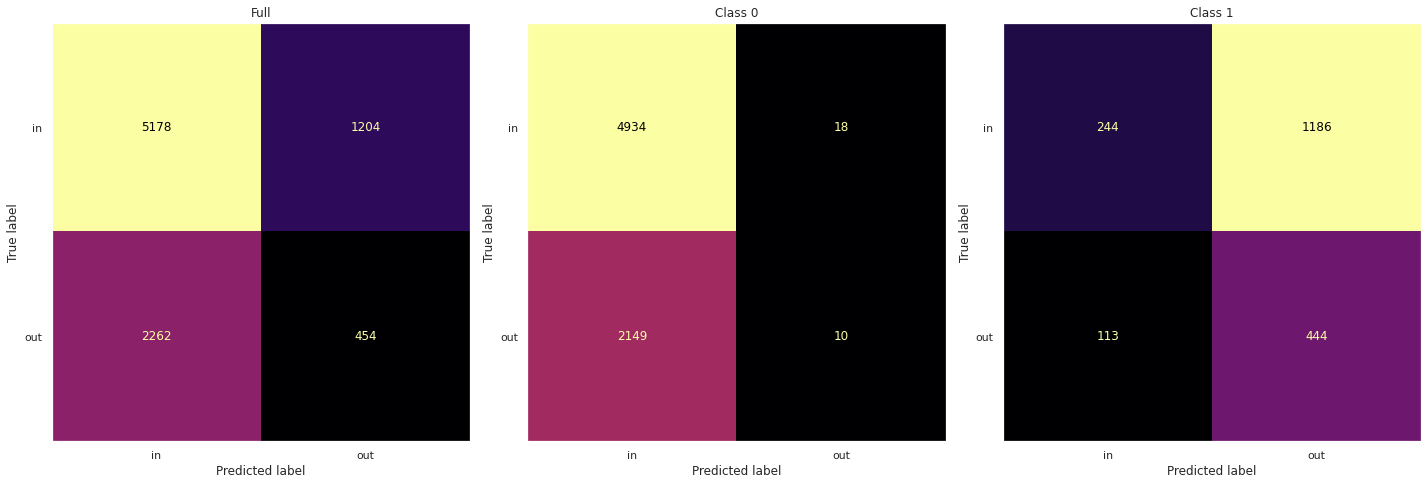

In [18]:
evaluate_attack(hv0, hv1, BB, BB_DATA)

## Soft Voting

In [19]:
sv0 = SoftVotingClassifier(classifiers=attack_models_0)
sv1 = SoftVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.78      0.74      6624
         out       0.28      0.20      0.24      2839

    accuracy                           0.61      9463
   macro avg       0.49      0.49      0.49      9463
weighted avg       0.57      0.61      0.59      9463


Class 0
              precision    recall  f1-score   support

          in       0.70      1.00      0.82      4965
         out       0.40      0.01      0.01      2165

    accuracy                           0.70      7130
   macro avg       0.55      0.50      0.42      7130
weighted avg       0.61      0.70      0.57      7130


Class 1
              precision    recall  f1-score   support

          in       0.67      0.14      0.23      1659
         out       0.28      0.83      0.42       674

    accuracy                           0.34      2333
   macro avg       0.48      0.49      0.33      2333
weighted avg       0.56      0.34      0.29 

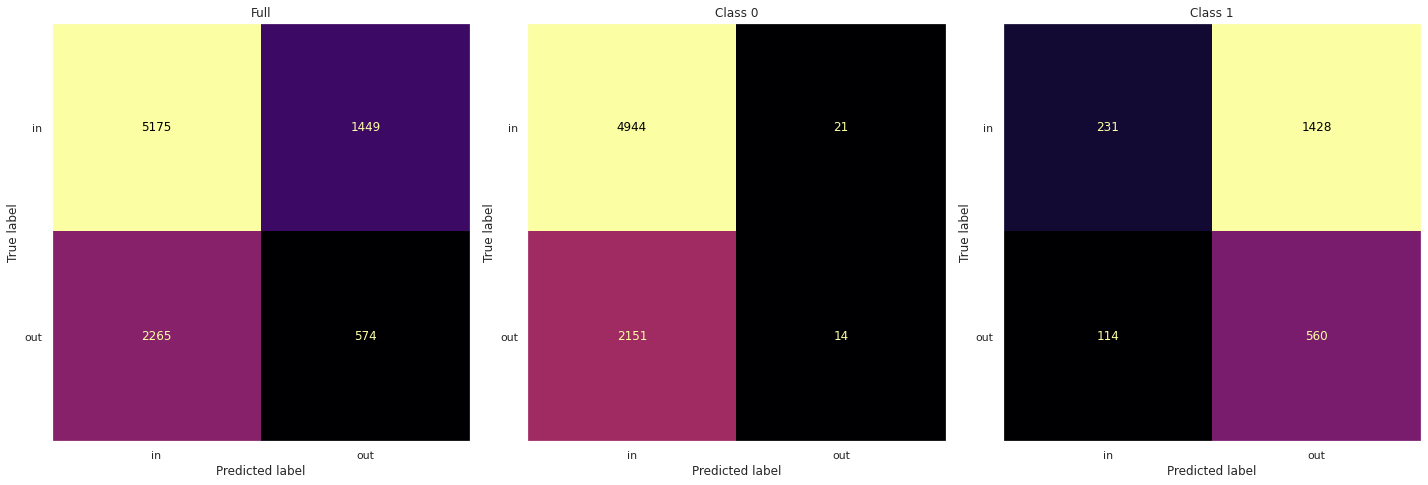

In [20]:
evaluate_attack(sv0, sv1, BB, BB_DATA)